In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.info() # Age, Cabin and Embarked have missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


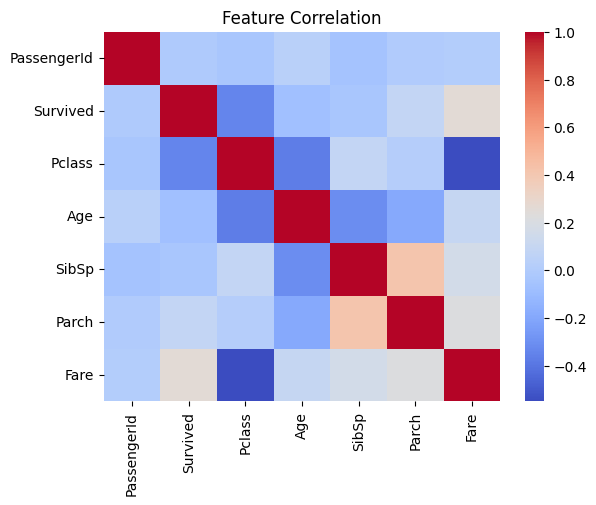

In [9]:
# Drop all non numeric features
correlation = df.corr(numeric_only=True)
plt.title("Feature Correlation")
sns.heatmap(correlation, cmap="coolwarm")
plt.show()

In [7]:
# SSS is used to evenly distribute the features "Survived", "Pclass" and "Sex" because of their high correlation.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df[["Survived", "Pclass", "Sex"]]):
    strat_train = df.loc[train_idx]
    strat_test = df.loc[test_idx]

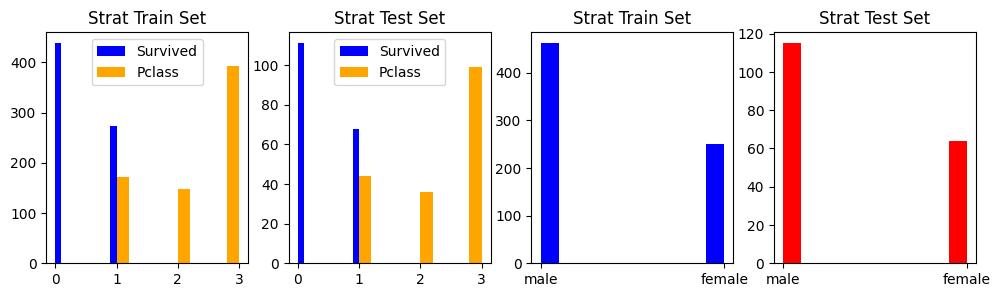

In [8]:
plt.figure(figsize=(12,3))

plt.subplot(1, 4, 1)
plt.title("Strat Train Set")
plt.hist(strat_train["Survived"], color='blue', label='Survived')
plt.hist(strat_train["Pclass"], color='orange', label='Pclass')
plt.legend()

plt.subplot(1, 4, 2)
plt.title("Strat Test Set")
plt.hist(strat_test["Survived"], color='blue', label='Survived')
plt.hist(strat_test["Pclass"], color='orange', label='Pclass')
plt.legend()

plt.subplot(1, 4, 3)
plt.title("Strat Train Set")
plt.hist(strat_train["Sex"], color='blue')

plt.subplot(1, 4, 4)
plt.title("Strat Test Set")
plt.hist(strat_test["Sex"], color='red')

plt.show()

### Data Cleaning

In [9]:
strat_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          565 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [10]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy="mean")
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["Age"] = self.imputer.fit_transform(X[["Age"]])
        return X

In [11]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = self.concat_encoded(X, "Embarked", ["C", "S", "Q", "N"])
        
        X = self.concat_encoded(X, "Sex", ["Female", "Male"])
        return X
    
    def concat_encoded(self, X, column, new_columns):
        encoder = OneHotEncoder()
        encoded = encoder.fit_transform(X[[column]])
        new_columns = new_columns[:encoded.shape[1]]
        tmp_df = pd.DataFrame(encoded.toarray(), columns=new_columns)
        tmp_df.index = X.index
        X = pd.concat([X, tmp_df], axis=1)
        return X


In [12]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], errors="ignore", axis=1)

In [13]:
pipeline = Pipeline([("ageImputer", AgeImputer()),
                     ("featureEncoder", FeatureEncoder()),
                     ("featureDropper", FeatureDropper())])

In [14]:
strat_train = pipeline.fit_transform(strat_train)

In [15]:
strat_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
867,868,0,1,31.0,0,0,50.4958,0.0,0.0,1.0,0.0,1.0
619,620,0,2,26.0,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
50,51,0,3,7.0,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
286,287,1,3,30.0,0,0,9.5000,0.0,0.0,1.0,0.0,1.0
834,835,0,3,18.0,0,0,8.3000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
482,483,0,3,50.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
518,519,1,2,36.0,1,0,26.0000,0.0,0.0,1.0,1.0,0.0
54,55,0,1,65.0,0,1,61.9792,1.0,0.0,0.0,0.0,1.0
603,604,0,3,44.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [16]:
strat_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 867 to 802
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [17]:
scaler = StandardScaler()

X_train = strat_train.drop(["Survived"], axis=1)
y_train = strat_train["Survived"]

X_train = scaler.fit_transform(X_train)
y_train = np.array(y_train)

### Random Forest Classifier

In [18]:
clf = RandomForestClassifier()

# RandomForest
param_grid = {
    'n_estimators': [10, 100, 200, 350, 500],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 3, 5, 7, 10]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 15, 20, 25, 30],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'n_estimators': [10, 100, 200, 350, 500]},
             return_train_score=True, scoring='accuracy')

In [19]:
final_clf = grid_search.best_estimator_

In [20]:
final_clf

RandomForestClassifier(max_depth=20, min_samples_split=10)

In [21]:
strat_test = pipeline.fit_transform(strat_test)

In [22]:
strat_test

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
659,660,0,1,58.00000,0,2,113.2750,1.0,0.0,0.0,0.0,1.0
119,120,0,3,2.00000,4,2,31.2750,0.0,0.0,1.0,1.0,0.0
875,876,1,3,15.00000,0,0,7.2250,1.0,0.0,0.0,1.0,0.0
67,68,0,3,19.00000,0,0,8.1583,0.0,0.0,1.0,0.0,1.0
644,645,1,3,0.75000,2,1,19.2583,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,1,3,33.00000,3,0,15.8500,0.0,0.0,1.0,1.0,0.0
687,688,0,3,19.00000,0,0,10.1708,0.0,0.0,1.0,0.0,1.0
538,539,0,3,29.44349,0,0,14.5000,0.0,0.0,1.0,0.0,1.0
279,280,1,3,35.00000,1,1,20.2500,0.0,0.0,1.0,1.0,0.0


In [23]:
scaler = StandardScaler()

X_test = strat_train.drop(["Survived"], axis=1)
y_test = strat_train["Survived"]

X_test = scaler.fit_transform(X_test)
y_test = np.array(y_test)

In [24]:
final_clf.score(X_test, y_test) # 0.9353932584269663

0.9157303370786517

In [25]:
final_df = pipeline.fit_transform(df)

In [26]:
final_df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [27]:
scaler = StandardScaler()

X_final = final_df.drop(["Survived"], axis=1)
y_final = final_df["Survived"]

X_final = scaler.fit_transform(X_final)
y_final = np.array(y_final)

In [28]:
clf = RandomForestClassifier()

# RandomForest
param_grid = {
    'n_estimators': [10, 100, 200, 350, 500],
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': [2, 3, 5, 7, 10]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True)
grid_search.fit(X_final, y_final)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 15, 20, 25, 30],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'n_estimators': [10, 100, 200, 350, 500]},
             return_train_score=True, scoring='accuracy')

In [29]:
prod_clf = grid_search.best_estimator_

In [30]:
test_df = pd.read_csv("data/test.csv")

In [31]:
test_df = pipeline.fit_transform(test_df)

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [33]:
X_final_test = test_df
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [34]:
predictions = prod_clf.predict(X_data_final_test)

In [35]:
final_df = pd.DataFrame(test_df["PassengerId"])
final_df["Survived"] = predictions
final_df.to_csv("data/predictions.csv", index=False)